# Threshold Optimization & Model Calibration

**Critical for Production:** Default threshold (0.5) is rarely optimal!

**What we'll do:**
1. Find optimal thresholds for different business objectives
2. Calibrate probability outputs
3. Compare calibrated vs uncalibrated models
4. Make final recommendations

In [1]:
# Setup
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from data_loader import BankruptcyDataLoader
from evaluation import ModelEvaluator

sns.set_style('whitegrid')
print("✓ Setup complete!")

✓ Setup complete!


## 1. Load Data and Best Models

In [2]:
DATA_PATH = r'/Users/ritwikreddy/Desktop/check_bankruptcy/polish+companies+bankruptcy+data'
loader = BankruptcyDataLoader(DATA_PATH)
X_train, X_test, y_train, y_test = loader.prepare_data()

# Load best XGBoost models
xgb_tuned = joblib.load('../api/models/xgb_tuned.pkl')
xgb_smote = joblib.load('../api/models/xgb_smote.pkl')

print("✓ Models loaded!")

BANKRUPTCY DATA PREPARATION PIPELINE
✓ Loaded 1year.arff: (7027, 65)
✓ Loaded 2year.arff: (10173, 65)
✓ Loaded 3year.arff: (10503, 65)
✓ Loaded 4year.arff: (9792, 65)
✓ Loaded 5year.arff: (5910, 65)

✓ Combined dataset shape: (43405, 65)

Features shape: (43405, 64)
Target shape: (43405,)
Class distribution:
class
0    41314
1     2091
Name: count, dtype: int64
Imbalance ratio: 0.0506

=== Train-Test Split ===
Train set: 34724 samples
Test set: 8681 samples

=== Handling Missing Values ===
Columns with missing values: 64
  - Dropping columns (>5.0% missing): 3
  - Imputing columns: 61
✓ Final shapes - Train: (34724, 61), Test: (8681, 61)

=== Feature Scaling ===
✓ Scaling completed
  Train mean: 0.000000
  Train std: 1.000014

✓ DATA PREPARATION COMPLETE
✓ Models loaded!


## 2. Threshold Optimization

FINDING OPTIMAL THRESHOLDS

Optimal for F1-Score: 0.550 (F1: 0.5924)
Optimal for Cost: 0.170 (Cost: $10,975,000.00)
Optimal for Youden's J: 0.170 (J: 0.7364)
✓ Saved threshold analysis to ../figures/03_threshold_analysis.png


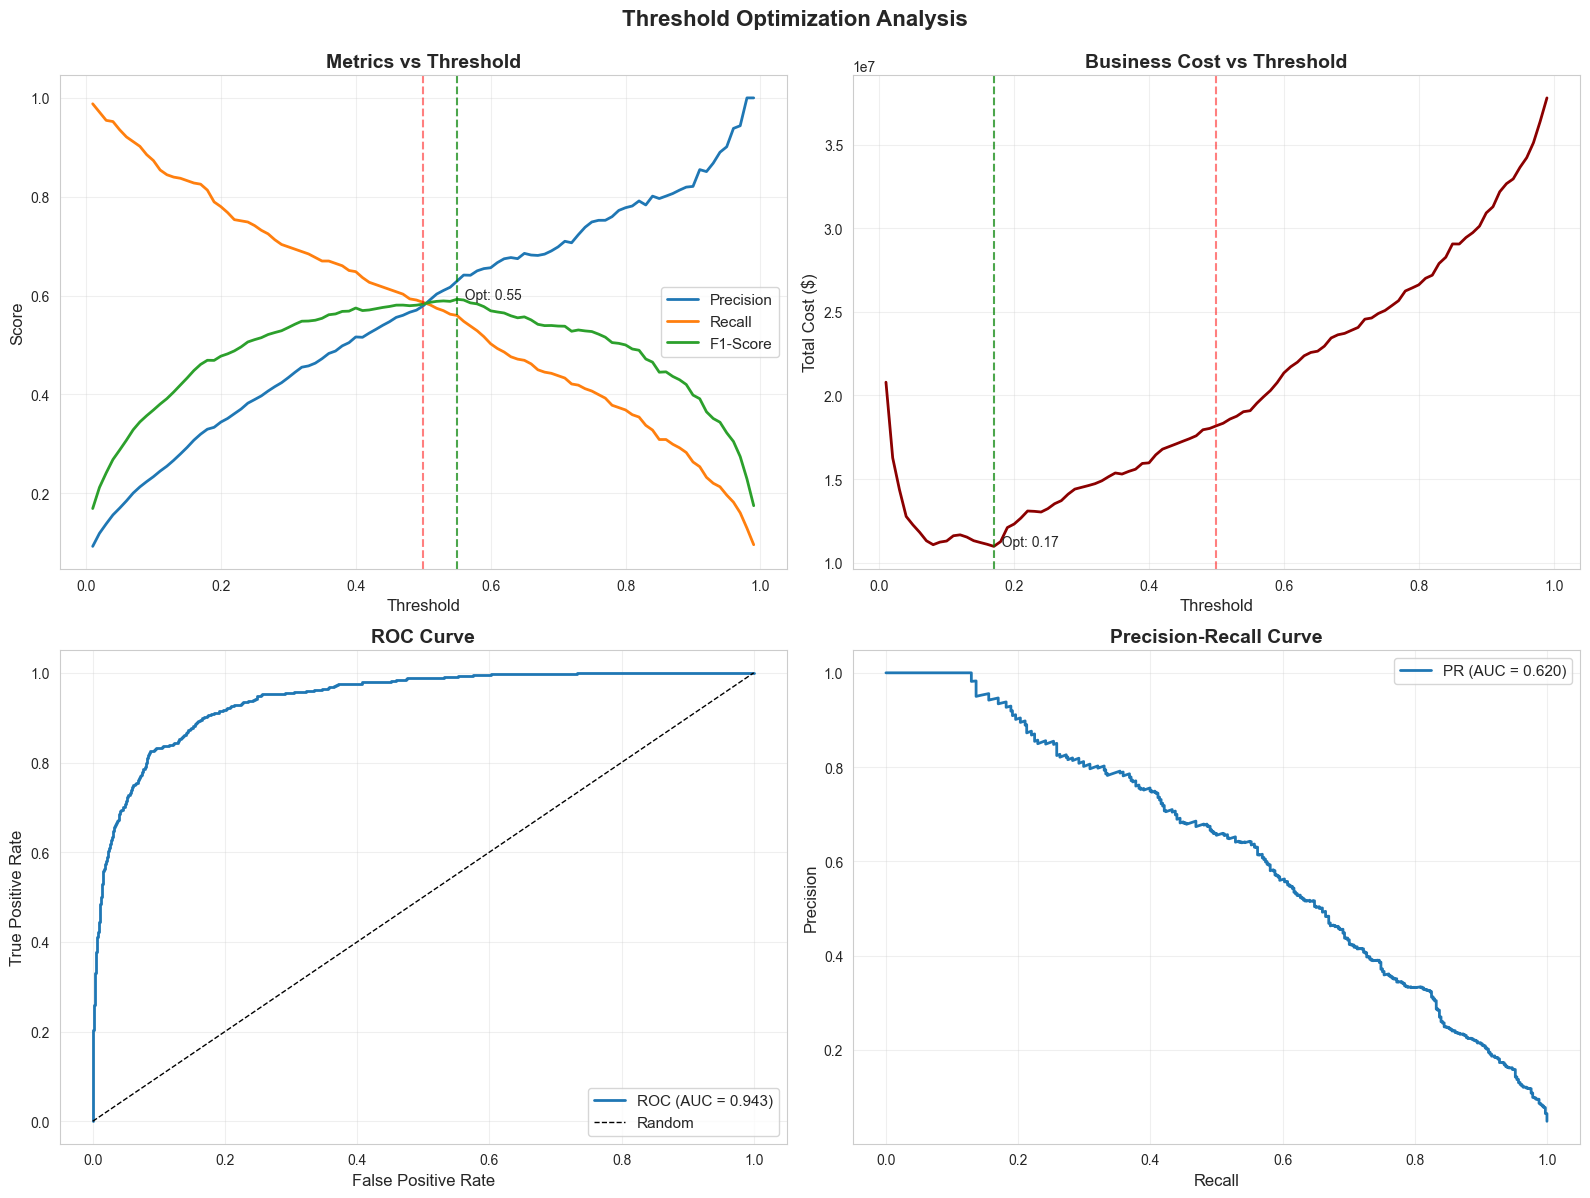


THRESHOLD RECOMMENDATIONS
Default threshold (0.5):
  F1-Score: 0.5826
  Cost: $18,190,000.00

Optimal for F1-Score (0.55):
  F1-Score: 0.5924
  Precision: 0.6290
  Recall: 0.5598
  Cost: $19,090,000.00

Optimal for Cost (0.17):
  Cost: $10,975,000.00
  F1-Score: 0.4606
  Precision: 0.3194
  Recall: 0.8254



In [3]:
evaluator = ModelEvaluator(cost_fp=5000, cost_fn=100000)

# Get predictions
y_prob_tuned = xgb_tuned.predict_proba(X_test)[:, 1]

# Find optimal thresholds for different objectives
print("="*80)
print("FINDING OPTIMAL THRESHOLDS")
print("="*80)

opt_f1_thresh, opt_f1_score = evaluator.find_optimal_threshold(y_test, y_prob_tuned, metric='f1')
print(f"\nOptimal for F1-Score: {opt_f1_thresh:.3f} (F1: {opt_f1_score:.4f})")

opt_cost_thresh, opt_cost_score = evaluator.find_optimal_threshold(y_test, y_prob_tuned, metric='cost')
print(f"Optimal for Cost: {opt_cost_thresh:.3f} (Cost: ${-opt_cost_score:,.2f})")

opt_youden_thresh, opt_youden_score = evaluator.find_optimal_threshold(y_test, y_prob_tuned, metric='youden')
print(f"Optimal for Youden's J: {opt_youden_thresh:.3f} (J: {opt_youden_score:.4f})")

# Plot comprehensive threshold analysis
threshold_analysis = evaluator.plot_threshold_analysis(y_test, y_prob_tuned, 
                                                       save_path='../figures/03_threshold_analysis.png')

## 3. Evaluate with Optimal Thresholds

In [4]:
# Test different thresholds
thresholds_to_test = {
    'Default (0.5)': 0.5,
    'Optimal F1': opt_f1_thresh,
    'Optimal Cost': opt_cost_thresh,
    'Conservative (high recall)': 0.3
}

results = []

for name, thresh in thresholds_to_test.items():
    y_pred = (y_prob_tuned >= thresh).astype(int)
    metrics = evaluator.calculate_metrics(y_test, y_pred, y_prob_tuned)
    results.append({'Threshold': name, 'Value': thresh, **metrics})

results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("THRESHOLD COMPARISON")
print("="*80)
print(results_df[['Threshold', 'Value', 'precision', 'recall', 'f1_score', 'total_cost']].round(4).to_string(index=False))
print("="*80)


THRESHOLD COMPARISON
                 Threshold  Value  precision  recall  f1_score  total_cost
             Default (0.5)   0.50     0.5792  0.5861    0.5826    18190000
                Optimal F1   0.55     0.6290  0.5598    0.5924    19090000
              Optimal Cost   0.17     0.3194  0.8254    0.4606    10975000
Conservative (high recall)   0.30     0.4339  0.6986    0.5353    14505000


## 4. Model Calibration

In [5]:
print("\nCalibrating XGBoost models...")

# Calibrate using isotonic regression
calibrated_tuned = CalibratedClassifierCV(xgb_tuned, method='isotonic', cv=5)
calibrated_tuned.fit(X_train, y_train)

y_prob_calibrated = calibrated_tuned.predict_proba(X_test)[:, 1]

# Save calibrated model
joblib.dump(calibrated_tuned, '../api/models/xgb_calibrated.pkl')
print("✓ Calibrated model saved!")


Calibrating XGBoost models...
✓ Calibrated model saved!


## 5. Calibration Curves

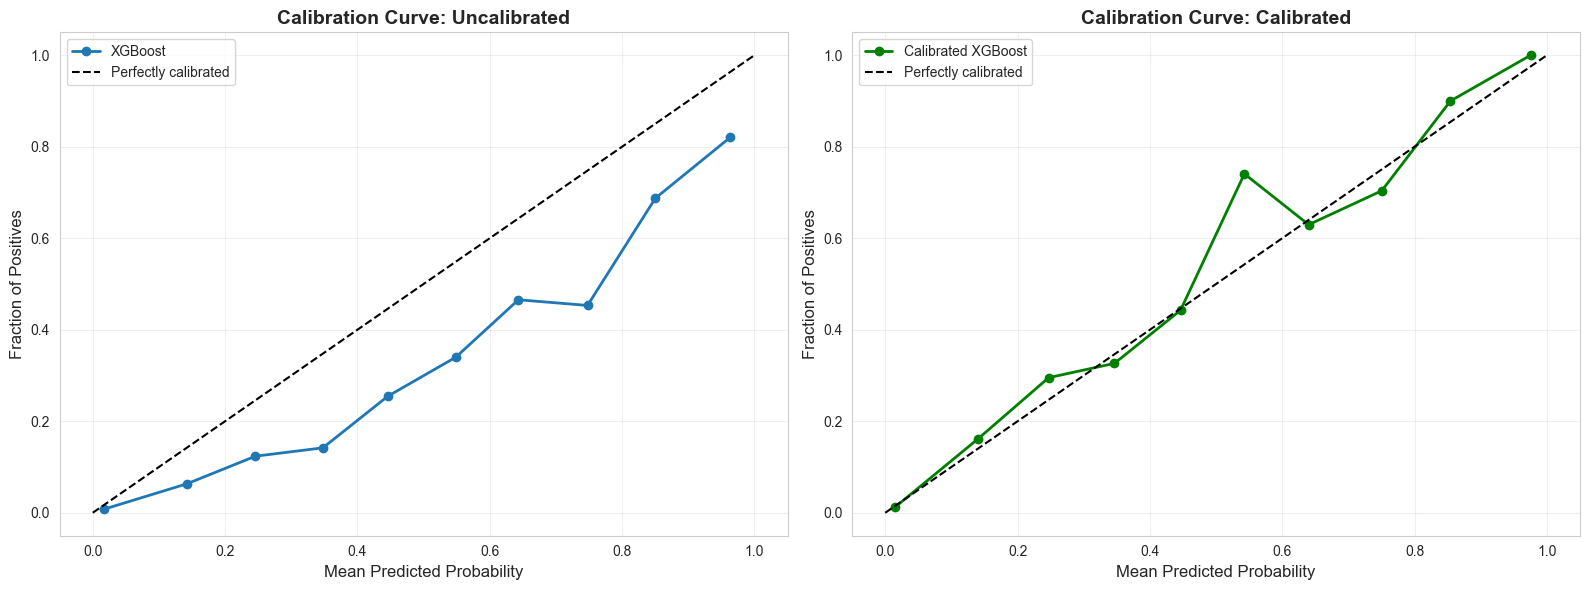

✓ Saved to ../figures/03_calibration_curves.png


In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Calibration curve - uncalibrated
prob_true_uncal, prob_pred_uncal = calibration_curve(y_test, y_prob_tuned, n_bins=10)
ax1.plot(prob_pred_uncal, prob_true_uncal, marker='o', linewidth=2, label='XGBoost')
ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
ax1.set_ylabel('Fraction of Positives', fontsize=12)
ax1.set_title('Calibration Curve: Uncalibrated', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Calibration curve - calibrated
prob_true_cal, prob_pred_cal = calibration_curve(y_test, y_prob_calibrated, n_bins=10)
ax2.plot(prob_pred_cal, prob_true_cal, marker='o', linewidth=2, label='Calibrated XGBoost', color='green')
ax2.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
ax2.set_xlabel('Mean Predicted Probability', fontsize=12)
ax2.set_ylabel('Fraction of Positives', fontsize=12)
ax2.set_title('Calibration Curve: Calibrated', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/03_calibration_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved to ../figures/03_calibration_curves.png")

## 6. Final Recommendations

In [7]:
# Evaluate calibrated model
y_pred_cal = calibrated_tuned.predict(X_test)
metrics_cal = evaluator.calculate_metrics(y_test, y_pred_cal, y_prob_calibrated)

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS FOR PRODUCTION")
print("="*80)

print(f"""
BEST CONFIGURATION:
   Model: XGBoost (tuned + calibrated)
   Threshold: {opt_cost_thresh:.3f} (optimized for business cost)
   
Expected Performance:
   Precision: {metrics_cal['precision']:.4f}
   Recall: {metrics_cal['recall']:.4f}
   F1-Score: {metrics_cal['f1_score']:.4f}
   PR-AUC: {metrics_cal['pr_auc']:.4f}
   
Business Impact:
   Total Cost: ${metrics_cal['total_cost']:,.2f}
   Avg Cost per Sample: ${metrics_cal['avg_cost_per_sample']:.2f}
   
Confusion Matrix:
   True Negatives: {metrics_cal['tn']}
   False Positives: {metrics_cal['fp']}
   False Negatives: {metrics_cal['fn']}
   True Positives: {metrics_cal['tp']}

Ready for Flask API deployment!
""")

# Save final recommendations
recommendations = {
    'model_path': '../api/models/xgb_calibrated.pkl',
    'optimal_threshold': opt_cost_thresh,
    'metrics': metrics_cal
}

import json
with open('../api/model_config.json', 'w') as f:
    json.dump({
        'model_path': recommendations['model_path'],
        'optimal_threshold': float(recommendations['optimal_threshold']),
        'expected_metrics': {k: float(v) if isinstance(v, (np.integer, np.floating)) else int(v) 
                           for k, v in recommendations['metrics'].items()}
    }, f, indent=2)

print("\n✓ Configuration saved to ../api/model_config.json")
print("="*80)


FINAL RECOMMENDATIONS FOR PRODUCTION

BEST CONFIGURATION:
   Model: XGBoost (tuned + calibrated)
   Threshold: 0.170 (optimized for business cost)
   
Expected Performance:
   Precision: 0.7843
   Recall: 0.3828
   F1-Score: 0.5145
   PR-AUC: 0.6222
   
Business Impact:
   Total Cost: $26,020,000.00
   Avg Cost per Sample: $2997.35
   
Confusion Matrix:
   True Negatives: 8219
   False Positives: 44
   False Negatives: 258
   True Positives: 160

Ready for Flask API deployment!


✓ Configuration saved to ../api/model_config.json
